In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
import matplotlib.pyplot as plt
from res.plot import set_default

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# The MNIST DataSet

In [4]:
train_set = datasets.MNIST('C:/Users/asbla/Documents/Resources/', 
                           train = True, 
                           transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(0,1)])
                          )

test_set  = datasets.MNIST('C:/Users/asbla/Documents/Resources/', 
                           train = False, 
                           transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(0,1)])
                          )

In [5]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

In [6]:
print(type(train_set))
print(type(train_set[0]))
print(type(train_set[0][0]))

<class 'torchvision.datasets.mnist.MNIST'>
<class 'tuple'>
<class 'torch.Tensor'>


In [7]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_set,  batch_size=256, shuffle=True)

In [8]:
imgs, labels = next(iter(train_loader))

In [9]:
print(imgs.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


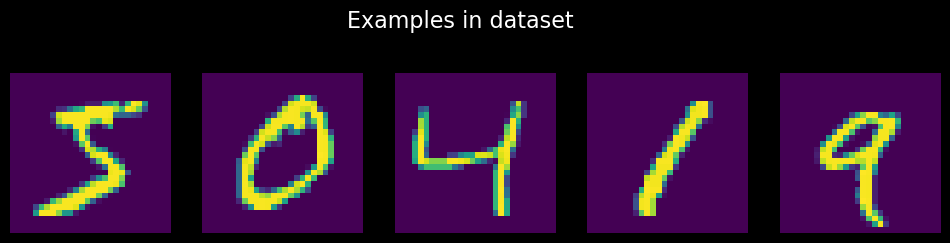

In [10]:
set_default((12,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(train_set[i][0].squeeze())
    plt.axis('off')
plt.suptitle('Examples in dataset', size=16)
plt.show()

# Fully Connected Two hidden layer Netwrok

In [11]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        
        self.linear1 = nn.Linear(input_size, n_hidden) 
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, output_size)
        
    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [12]:
n_hidden = 8 # number of hidden units

model_fc = FC2Layer(input_size, n_hidden, output_size)
model_fc.to(device)

optimizer = optim.SGD(model_fc.parameters(), lr=0.01, momentum=0.5)

In [13]:
params=0
for p in list(model_fc.parameters()):
    params += p.nelement()
print(f'Number of parameters: {params}')

Number of parameters: 6442


In [14]:
def train(model, train_loader, epochs):
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            # forward Propagation
            optimizer.zero_grad()
            output = model(data)
            
            # Compute Loss
            loss   = F.nll_loss(output, target)
            
            # backward Propagation
            loss.backward()
            
            # Optimisation step (weight updates)
            optimizer.step()

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{}] \tLoss: {:.6f}'.format(
                    epoch, 
                    batch_idx*len(data), len(train_loader.dataset),
                    loss.item()))

In [15]:
train(model_fc, train_loader, 1)

Train Epoch: 0 [0/60000] 	Loss: 2.285449
Train Epoch: 0 [6400/60000] 	Loss: 2.212178
Train Epoch: 0 [12800/60000] 	Loss: 2.013342
Train Epoch: 0 [19200/60000] 	Loss: 1.921452
Train Epoch: 0 [25600/60000] 	Loss: 1.786750
Train Epoch: 0 [32000/60000] 	Loss: 1.365377
Train Epoch: 0 [38400/60000] 	Loss: 0.924513
Train Epoch: 0 [44800/60000] 	Loss: 0.985812
Train Epoch: 0 [51200/60000] 	Loss: 0.694538
Train Epoch: 0 [57600/60000] 	Loss: 0.667440


In [16]:
def test(model, test_loader):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
    
        output = model(data)
        
        #[1] -> to get the index of the max log-probability                                                                  
        pred = output.data.max(dim=1, keepdim=True)[1]                                                            
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        accuracy))

In [17]:
test(model_fc, test_loader)


Test set: Accuracy: 8163/10000 (82%)



# Convolutional Neural Network with same number of total parameters

## Assumptions
### 1. Locality - Sparsity
- Nearby things are more likely to be related.

### 2. Stationarity - Parameter Sharing
- Certain pattern can appear anywhere in the field.

### 3. Compositionality - Multi layer
- The idea that everything is made up of parts that are made up of sub-parts and so on.. Compositionality allows for explainability. 

In [18]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, output_size)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        x = x.view(-1, self.n_feature*4*4)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [19]:
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)

optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)

In [20]:
params=0
for p in list(model_cnn.parameters()):
    params += p.nelement()
print(f'Number of parameters: {params}')

Number of parameters: 6422


In [21]:
train(model_cnn, train_loader, 1)

Train Epoch: 0 [0/60000] 	Loss: 2.301472
Train Epoch: 0 [6400/60000] 	Loss: 2.282376
Train Epoch: 0 [12800/60000] 	Loss: 2.260879
Train Epoch: 0 [19200/60000] 	Loss: 1.754123
Train Epoch: 0 [25600/60000] 	Loss: 1.048190
Train Epoch: 0 [32000/60000] 	Loss: 0.682688
Train Epoch: 0 [38400/60000] 	Loss: 0.488626
Train Epoch: 0 [44800/60000] 	Loss: 0.332008
Train Epoch: 0 [51200/60000] 	Loss: 0.272197
Train Epoch: 0 [57600/60000] 	Loss: 0.389097


In [22]:
test(model_cnn, test_loader)


Test set: Accuracy: 8984/10000 (90%)



# Diverging from the Assumptions of CNN

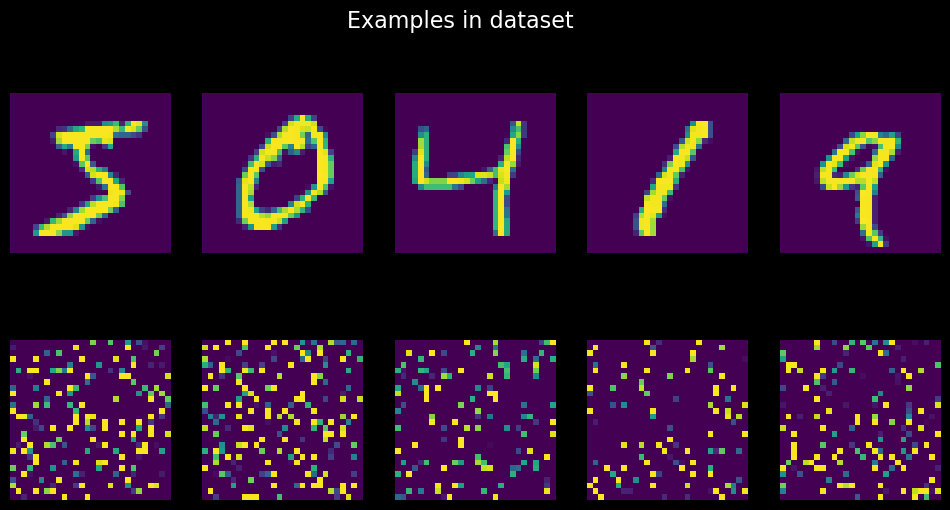

In [23]:
perm = torch.randperm(784)

set_default((12,6))
for i in range(5):
    image = train_set[i][0]
    
    plt.subplot(2,5, i+1)
    plt.imshow(image.squeeze())
    plt.axis('off')
    
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    
    plt.subplot(2,5, 5+i+1)
    plt.imshow(image_perm.squeeze())
    plt.axis('off')
    
plt.suptitle('Examples in dataset', size=16)
plt.show()

In [24]:
def train_perm(model, train_loader, epochs, perm):
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            data = data.view(-1, 28*28).clone()
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)
        
            # forward Propagation
            optimizer.zero_grad()
            output = model(data)
            
            # Compute Loss
            loss   = F.nll_loss(output, target)
            
            # backward Propagation
            loss.backward()
            
            # Optimisation step (weight updates)
            optimizer.step()

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{}] \tLoss: {:.6f}'.format(
                    epoch, 
                    batch_idx*len(data), len(train_loader.dataset),
                    loss.item()))

In [25]:
def test_perm(model, test_loader, perm):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
    
        data = data.view(-1, 28*28).clone()
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
    
        output = model(data)
        
        #[1] -> to get the index of the max log-probability                                                                  
        pred = output.data.max(dim=1, keepdim=True)[1]                                                            
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        accuracy))

In [26]:
n_hidden = 8 # number of hidden units

model_fc = FC2Layer(input_size, n_hidden, output_size)
model_fc.to(device)

optimizer = optim.SGD(model_fc.parameters(), lr=0.01, momentum=0.5)

In [27]:
train_perm(model_fc, train_loader, 1, perm)

Train Epoch: 0 [0/60000] 	Loss: 2.318180
Train Epoch: 0 [6400/60000] 	Loss: 2.231887
Train Epoch: 0 [12800/60000] 	Loss: 2.089429
Train Epoch: 0 [19200/60000] 	Loss: 2.001812
Train Epoch: 0 [25600/60000] 	Loss: 1.504731
Train Epoch: 0 [32000/60000] 	Loss: 1.415200
Train Epoch: 0 [38400/60000] 	Loss: 0.957074
Train Epoch: 0 [44800/60000] 	Loss: 1.194509
Train Epoch: 0 [51200/60000] 	Loss: 0.952248
Train Epoch: 0 [57600/60000] 	Loss: 0.697604


In [28]:
test_perm(model_fc, test_loader, perm)


Test set: Accuracy: 7886/10000 (79%)



In [29]:
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)

optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)

In [30]:
train_perm(model_cnn, train_loader, 1, perm)

Train Epoch: 0 [0/60000] 	Loss: 2.310347
Train Epoch: 0 [6400/60000] 	Loss: 2.314252
Train Epoch: 0 [12800/60000] 	Loss: 2.275862
Train Epoch: 0 [19200/60000] 	Loss: 2.294259
Train Epoch: 0 [25600/60000] 	Loss: 2.246100
Train Epoch: 0 [32000/60000] 	Loss: 2.228028
Train Epoch: 0 [38400/60000] 	Loss: 2.137091
Train Epoch: 0 [44800/60000] 	Loss: 2.128325
Train Epoch: 0 [51200/60000] 	Loss: 1.982811
Train Epoch: 0 [57600/60000] 	Loss: 1.730322


In [31]:
test_perm(model_cnn, test_loader, perm)


Test set: Accuracy: 4085/10000 (41%)

